In [5]:
import pandas as pd
import numpy as np
import random 
from matplotlib import pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

%matplotlib inline

In [6]:
sales =pd.read_excel('retail_sales.xlsx')

In [7]:
sales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [8]:
len(sales.index)

541909

In [9]:
sales.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
sales = sales.drop('Country',axis=1)

Preliminary exploration has shown that there are negative values for unit price and quantity. This does not seem right because none of these variables should'nt have a negative value.

In [13]:
nosales = sales[sales["Quantity"] < 0]
print("Length of data with negative quantity: " + str(len(nosales.index)))
nosales.head()

Length of data with negative quantity: 10624


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0


In [14]:
noprice = sales[sales["UnitPrice"] < 0]
print("Length of data with negative price: " + str(len(noprice.index)))
print(noprice)

Length of data with negative price: 2
       InvoiceNo StockCode      Description  Quantity         InvoiceDate  \
299983   A563186         B  Adjust bad debt         1 2011-08-12 14:51:00   
299984   A563187         B  Adjust bad debt         1 2011-08-12 14:52:00   

        UnitPrice  CustomerID  
299983  -11062.06         NaN  
299984  -11062.06         NaN  


In [17]:
frames = [noprice, nosales]
result = pd.concat(frames)

newsales = sales[~sales["InvoiceNo"].isin(result["InvoiceNo"])]

Now with the negative values have been dealt with, it is time to focus on the missing values. From the isnull function it was seen that there are 135080 customer IDs missing and 1454 product names missing as well.

In [18]:
nocusID  = newsales[sales["CustomerID"].isnull()]
len(nocusID.index)

C:\Users\nrssm\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


133359

In [19]:
noPN = newsales[newsales["Description"].isnull()]
len(noPN.index)

592

In [20]:
listPN = noPN["StockCode"].tolist()
len(newsales[newsales["StockCode"].isin(listPN)].index)

48967

In [21]:
noPN.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN


In [22]:
noID_PN = newsales[newsales["CustomerID"].isnull() & newsales["Description"].isnull()]
len(noID_PN.index)

592

The 1454 records that don't have Product Name don't have Customer ID either. Also the ProductName can be matched to the ProductID but it would be better to remove these values from the dataframe because they have 0 UnitPrice. This may be because it could have been a test transaction. For simplicity, it's better to remove these.

In [23]:
#Removing observations with no product names#Removin 
newsales = newsales[~newsales["Description"].isnull()]
len(newsales.index)

530691

In [24]:
#Replacing the missing Customer ID with randomly choosing customerID from the dataset#Replaci 
newsales["CustomerID"].fillna(lambda x: random.choice(newsales[newsales["CustomerID"] != np.nan]["CustomerID"]), inplace = True)

In [25]:
#Checking for any missing values#Checkin 
newsales.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
dtype: int64

In [26]:
zeroUnitP  = newsales[newsales["UnitPrice"] == 0]
len(zeroUnitP.index)

587

In [27]:
newsales = newsales[~(newsales["UnitPrice"] == 0)]

## EDA
The following section explores different aspects of the data and aims to make deductions about customer purchases. First aspect explored is which item had the most quantity of item sold. As seen below the top 5 items in this category have been plotted with "Paper Craft, Little Birdie" bring the most popular

In [28]:
mostsoldprod  = newsales.groupby(["StockCode", "Description"])["Quantity"].sum().reset_index().sort_values("Quantity", ascending = False)

mostsoldprod.reset_index(level = 0, inplace=True)
del mostsoldprod["index"]

mostsoldprod.head(10)

,StockCode,Description,Quantity
0,23843,"PAPER CRAFT , LITTLE BIRDIE",80995
1,23166,MEDIUM CERAMIC TOP STORAGE JAR,78033
2,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,55047
3,85099B,JUMBO BAG RED RETROSPOT,48474
4,85123A,WHITE HANGING HEART T-LIGHT HOLDER,37599
5,22197,POPCORN HOLDER,36761
6,84879,ASSORTED COLOUR BIRD ORNAMENT,36461
7,21212,PACK OF 72 RETROSPOT CAKE CASES,36419
8,23084,RABBIT NIGHT LIGHT,30788
9,22492,MINI PAINT SET VINTAGE,26633


Text(0.5,1,'Most Quantities of Items Sold')

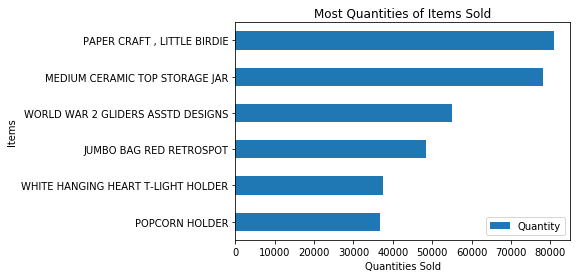

In [29]:
top5 = mostsoldprod.loc[0:5,["Description", "Quantity"]].sort_values("Quantity", ascending = True)
top5

top5.plot(kind = "barh", x = "Description", align = "center")
plt.ylabel('Items')
plt.xlabel('Quantities Sold')
plt.title('Most Quantities of Items Sold')

Another aspect that is examined was which product made the most sale. For this, the unit price was multiplied by the quantity and the values were stored in new NetSale column. The barchart shows the the product that made the most sale.

In [30]:
newsales["NetSales"] = newsales["Quantity"] * newsales["UnitPrice"]

In [31]:
highgrossprod = newsales.groupby(["StockCode","Description"])["NetSales"].sum().sort_values(ascending = False)
highgrossprod.head(5)

StockCode  Description                       
DOT        DOTCOM POSTAGE                        206248.77
22423      REGENCY CAKESTAND 3 TIER              174484.74
23843      PAPER CRAFT , LITTLE BIRDIE           168469.60
85123A     WHITE HANGING HEART T-LIGHT HOLDER    104340.29
47566      PARTY BUNTING                          99504.33
Name: NetSales, dtype: float64

Text(0.5,1,'Most Sold Products')

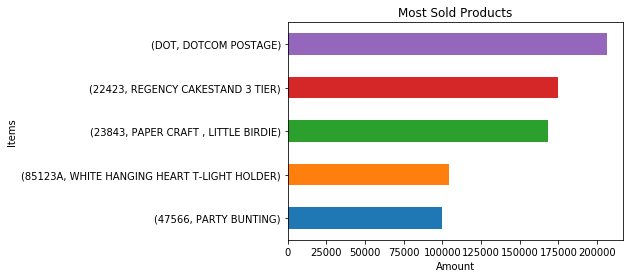

In [32]:
top5gros = highgrossprod[:5,].sort_values(ascending = True)

top5gros.plot(kind = "barh", x = "Description", align = "center")
plt.ylabel('Items')
plt.xlabel('Amount')
plt.title('Most Sold Products')

Lets find the products which were most frequently sold

In [33]:
freqprod = newsales.groupby(["StockCode", "Description"])["Description"].count().sort_values(axis = 0, ascending = False)
freqprod.head(5)

StockCode  Description                       
85123A     WHITE HANGING HEART T-LIGHT HOLDER    2256
85099B     JUMBO BAG RED RETROSPOT               2112
22423      REGENCY CAKESTAND 3 TIER              2017
47566      PARTY BUNTING                         1706
20725      LUNCH BAG RED RETROSPOT               1594
Name: Description, dtype: int64

Text(0.5,1,'Most Frequently Sold Products')

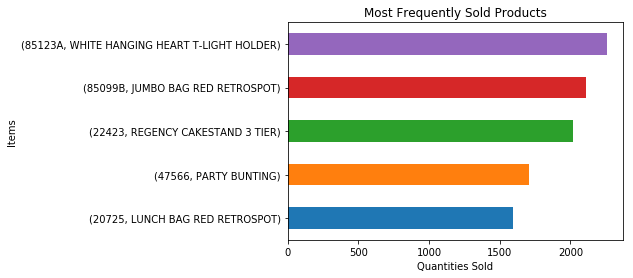

In [34]:
top5freq = freqprod[:5,].sort_values(ascending = True)

top5freq.plot(kind = "barh")
plt.ylabel('Items')
plt.xlabel('Quantities Sold')
plt.title('Most Frequently Sold Products')

Lets explore time, week and months in which the stores had most transactions

In [35]:
newsales["InvoiceDate"] = pd.to_datetime(newsales["InvoiceDate"])

In [36]:
newsales["Hour"] = newsales["InvoiceDate"].dt.hour
newsales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,NetSales,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,15.30,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,20.34,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,22.00,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,20.34,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,20.34,8


In [37]:
salesbyhour = newsales.groupby(["Hour"])["InvoiceNo"].count()

Text(0.5,1,'Transaction throughout the day')

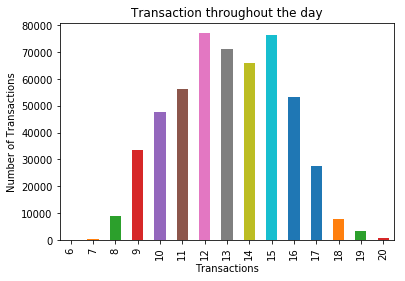

In [38]:
salesbyhour.plot(kind = "bar", x = "InvoiceNo")
plt.xlabel("Transactions")
plt.ylabel("Number of Transactions")
plt.title("Transaction throughout the day")

The transactions were carried out between 6 AM to 8 PM and 11AM to 4 PM were the busiest time of the day.

In [39]:
salesbyweek = newsales.groupby(["StockCode", 
                                pd.Grouper(key = "InvoiceDate", 
                                           freq = "W-MON")])["Quantity"].sum().reset_index().sort_values("Quantity", 
                                                                                                         ascending = False)

In [40]:
newsales['weekday'] = newsales['InvoiceDate'].dt.weekday_name
newsales["weekday"] = newsales["weekday"].astype('O')

Text(0.5,1,'')

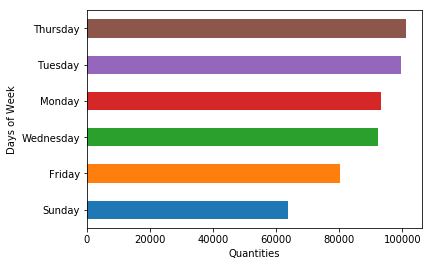

In [41]:
wd = newsales.groupby(['weekday'])['InvoiceNo'].count().sort_values(ascending = True)

wd.plot(kind = "barh")
plt.xlabel("Quantities")
plt.ylabel("Days of Week")
plt.title("")

In [42]:
print(newsales["InvoiceDate"].min())
print(newsales["InvoiceDate"].max())

2010-12-01 08:26:00
2011-12-09 12:50:00


In [43]:
newsales['Month'] = newsales['InvoiceDate'].dt.strftime('%b')
newsales["Month"] = newsales["Month"].astype('O')

m = newsales.groupby(['Month'])['InvoiceNo'].count().sort_values(ascending = True)

m.head()

Month
Feb    27105
Apr    29096
Jan    34306
Aug    34483
Mar    35803
Name: InvoiceNo, dtype: int64

Text(0.5,1,'Months with Most Quantities')

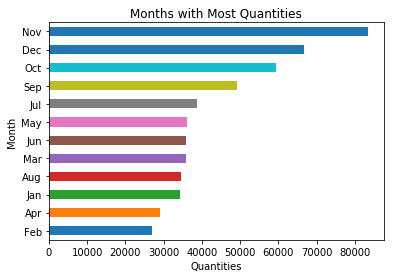

In [44]:
m.plot(kind = "barh")
plt.xlabel("Quantities")
plt.ylabel("Month")
plt.title("Months with Most Quantities")

Finally, given that the dataset ranges over an entire year, November was considered to be the month with the most amoubnt of transactions. This makes sense because it is closer to Christmas.

## Market Basket Analysis Using Association Analysis
Market Basket Analysis is one of the key techniques used by large retailers to uncover associations between items. It works by looking for combinations of items that occur together frequently in transactions. To put it another way, it allows retailers to identify relationships between the items that people buy.

Association Rules are widely used to analyze retail basket or transaction data, and are intended to identify strong rules discovered in transaction data using measures of interestingness, based on the concept of strong rules.

Some of the metric to consider in assoication analysis is as follows:

Support: The fraction of which our item set occurs in our dataset.
Confidence: probability that a rule is correct for a new transaction with items on the left.
Lift: The ratio by which by the confidence of a rule exceeds the expected confidence.
Equations for Association Analysis

First a matrix is created with StockCode as the index and Description as the columns and the matrix is populated with the quantities of each item. The quantity values are hot encoded to create a sparse matrix with 1s and 0s.

In [45]:
basket = (newsales.groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

In [46]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)
basket_sets.drop('POSTAGE', inplace=True, axis=1)
basket_sets.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Apriori algorithm was used to calculate the lift, support and confidence. The results were filtered to show items that can bought together which have more than 6 lift and confidence of 0.8.

In [47]:
frequent_itemsets = apriori(basket_sets, min_support=0.02, use_colnames=True)

In [48]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(LUNCH BAG CARS BLUE),(LUNCH BAG PINK POLKADOT),0.057615,0.054609,0.025150,0.436522,7.993554,0.022004,1.677777
1,(LUNCH BAG PINK POLKADOT),(LUNCH BAG CARS BLUE),0.054609,0.057615,0.025150,0.460550,7.993554,0.022004,1.746938
2,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.061022,0.104659,0.041333,0.677340,6.471855,0.034946,2.774873
3,(JUMBO BAG RED RETROSPOT),(JUMBO BAG PINK POLKADOT),0.104659,0.061022,0.041333,0.394926,6.471855,0.034946,1.551839
4,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.050752,0.038327,0.031663,0.623889,16.278213,0.029718,2.556890


In [49]:
rules[(rules['lift'] >= 6) & (rules['confidence'] >= 0.8)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.038327,0.050752,0.031663,0.826144,16.278213,0.029718,5.459963
23,"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",(GREEN REGENCY TEACUP AND SAUCER),0.029960,0.050752,0.027104,0.904682,17.825724,0.025584,9.958782
24,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.031663,0.053357,0.027104,0.856013,16.043204,0.025415,6.574490
41,"(REGENCY CAKESTAND 3 TIER, GREEN REGENCY TEACU...",(ROSES REGENCY TEACUP AND SAUCER ),0.025501,0.053357,0.020441,0.801572,15.022884,0.019080,4.770707
53,"(JUMBO BAG PINK POLKADOT, JUMBO STORAGE BAG SUKI)",(JUMBO BAG RED RETROSPOT),0.025802,0.104659,0.020691,0.801942,7.662402,0.017991,4.520593


## Recommender System - Item Based Collaborative Filtering
Item based collaborative filtering is a model-based algorithm for recommender engines. In item based collaborative filtering similarities between items are calculated from rating-matrix. And based upon these similarities, user’s preference for an item not rated by him is calculated. In this case, quantities is used as a measure of "rating". This might not be the most accurate way but would provide strong similarities between products that are bought in bulk.

First a matrix of CustomerID and ProductName is created just like we did for association analysis using pandas pivot table function and the NaNs are filled with zeroes.

In [58]:
matrix = newsales.pivot_table(index = ["CustomerID"], columns = ["Description"], 
                              values = "Quantity")
matrix.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12347.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12348.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12349.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12350.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Then a product is selected to see which customers have bought this product. The ones's who have will have show the quantity they have bought and the ones who have not will have NaN shown. In this case we have chosen the WHITE HANGING HEART T-LIGHT HOLDER.

In [59]:
whiteHeart = matrix["WHITE HANGING HEART T-LIGHT HOLDER"]
whiteHeart.head()

CustomerID
12346.0   NaN
12347.0   NaN
12348.0   NaN
12349.0   NaN
12350.0   NaN
Name: WHITE HANGING HEART T-LIGHT HOLDER, dtype: float64

A correlation matrix is created for the WHITE HANGING HEART T-LIGHT HOLDER to see which products are similar to this product.

In [61]:
similarProductsW  = matrix.corrwith(whiteHeart)
similarProductsW = similarProductsW.dropna()
df = pd.DataFrame(similarProductsW)
df.head(10)

,0
Description,
4 PURPLE FLOCK DINNER CANDLES,0.424009
50'S CHRISTMAS GIFT BAG LARGE,0.739869
DOLLY GIRL BEAKER,0.964077
I LOVE LONDON MINI BACKPACK,0.988855
NINE DRAWER OFFICE TIDY,0.640473
OVAL WALL MIRROR DIAMANTE,0.642959
RED SPOT GIFT BAG LARGE,0.490105
SET 2 TEA TOWELS I LOVE LONDON,0.599921
SPACEBOY BABY GIFT SET,0.358199


In [64]:
similarProductsW.sort_values(ascending = False)

Description
MAGAZINE RACK GEBRA ASSORTED           1.0
LUNCH BAG VINTAGE DOILEY               1.0
SILVER M.O.P ORBIT DROP EARRINGS       1.0
CROCHET WHITE RABBIT KEYRING           1.0
RED   ACRYLIC FACETED BANGLE           1.0
ASS COL CIRCLE MOBILE                  1.0
PURPLE ENAMEL FLOWER HAIR TIE          1.0
PURPLE ACRYLIC FACETED BANGLE          1.0
VINTAGE ZINC WATERING CAN              1.0
VINTAGE KITCHEN PRINT VEGETABLES       1.0
VINTAGE KITCHEN PRINT SEAFOOD          1.0
POTTING SHED CANDLE CITRONELLA         1.0
FOLKART CHRISTMAS TREE T-LIGHT HOLD    1.0
VINTAGE KEEPSAKE BOX TRAVELOGUE        1.0
VINTAGE KEEPSAKE BOX PARIS DAYS        1.0
ASSTD RASTA KEY-CHAINS                 1.0
FOLDING MIRROR HOT PINK                1.0
VINTAGE ENAMEL & CRYSTAL EARRINGS      1.0
BUTTERFLY HAIR BAND                    1.0
MIRROR MOSAIC GOBLET CANDLE HOLDER     1.0
DIAMANTE HAIR GRIP PACK/2 CRYSTAL      1.0
SILVER M.O.P ORBIT BRACELET            1.0
RED POLKADOT PUDDING BOWL              1.0

It seems like a like there are a lot of products that have high correlation(similarity) with the WHITE HANGING HEART T-LIGHT HOLDER.

However, to make our recommendation more accurate and user specific we choose a customer from the dataset, see what she has bought and see which products are the closest to the ones she has bought using the correlation matrix.

Below is a similarity matrix. It has all the products that have a good relationship with each other.

In [65]:
corrMatrix = matrix.corr()
corrMatrix.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
Description,,,,,,,,,,,,,,,,,,,,,
4 PURPLE FLOCK DINNER CANDLES,1.0,NaN,1.000000,1.000000,NaN,NaN,1.000000,NaN,-0.354149,1.000000,...,NaN,NaN,0.993399,-0.512360,NaN,0.995818,NaN,0.806896,NaN,-1.000000
50'S CHRISTMAS GIFT BAG LARGE,NaN,1.000000,0.603812,0.769729,NaN,0.852291,0.964546,0.998134,0.992207,0.549769,...,NaN,NaN,0.778490,0.488225,NaN,0.623481,NaN,0.557135,NaN,1.000000
DOLLY GIRL BEAKER,1.0,0.603812,1.000000,0.978350,NaN,0.693375,0.999408,0.464894,0.915639,0.777026,...,NaN,NaN,0.965592,0.993510,NaN,0.988722,NaN,0.999792,1.0,0.855549
I LOVE LONDON MINI BACKPACK,1.0,0.769729,0.978350,1.000000,NaN,-0.050401,0.908775,0.278111,0.670366,0.893828,...,NaN,NaN,0.992498,0.982926,NaN,0.999849,NaN,0.982725,NaN,0.972498
I LOVE LONDON MINI RUCKSACK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
second_customer = matrix.iloc[1].dropna()
second_customer.head()

Description
3D DOG PICTURE PLAYING CARDS      25.2
3D SHEET OF CAT STICKERS          12.0
3D SHEET OF DOG STICKERS          12.0
60 TEATIME FAIRY CAKE CASES       24.0
72 SWEETHEART FAIRY CAKE CASES    24.0
Name: 12347.0, dtype: float64

In [67]:
simProducts = pd.Series()
#Go through every product bought by second customer
for i in range(0, len(second_customer.index)):
    print "Adding sims for " + second_customer.index[i] + "...."
    #Retrieve similar products to the ones bought by customer 2
    sims = corrMatrix[second_customer.index[i]].dropna()
    #Scale to how many of the products were bought
    sims = sims.map(lambda x: x * second_customer[i])
    # Add to the list of similar products
    simProducts = simProducts.append(sims)

print("sorting...")
simProducts.sort_values(inplace = True, ascending = True)
print(simProducts)

Adding sims for 3D DOG PICTURE PLAYING CARDS....
Adding sims for 3D SHEET OF CAT STICKERS....
Adding sims for 3D SHEET OF DOG STICKERS....
Adding sims for 60 TEATIME FAIRY CAKE CASES....
Adding sims for 72 SWEETHEART FAIRY CAKE CASES....
Adding sims for AIRLINE BAG VINTAGE JET SET BROWN....
Adding sims for AIRLINE BAG VINTAGE JET SET RED....
Adding sims for AIRLINE BAG VINTAGE JET SET WHITE....
Adding sims for AIRLINE BAG VINTAGE TOKYO 78....
Adding sims for AIRLINE BAG VINTAGE WORLD CHAMPION ....
Adding sims for ALARM CLOCK BAKELIKE CHOCOLATE....
Adding sims for ALARM CLOCK BAKELIKE GREEN....
Adding sims for ALARM CLOCK BAKELIKE ORANGE....
Adding sims for ALARM CLOCK BAKELIKE PINK....
Adding sims for ALARM CLOCK BAKELIKE RED ....
Adding sims for BATHROOM METAL SIGN ....
Adding sims for BICYCLE PUNCTURE REPAIR KIT ....
Adding sims for BIRDCAGE DECORATION TEALIGHT HOLDER....
Adding sims for BLACK CANDELABRA T-LIGHT HOLDER....
Adding sims for BLACK EAR MUFF HEADPHONES....
Adding sims for

In [68]:
#Sorting the results and avoid repetitions#Sorting  
simProducts= simProducts.groupby(simProducts.index).sum().sort_values(ascending = False)

In [70]:
filteredSims  = simProducts.drop(second_customer.index)
filteredSims.head(5)

PACK OF 6 LARGE FRUIT STRAWS          1253.806740
JIGSAW TREE WITH BIRDHOUSE            1248.570850
16 PIECE CUTLERY SET PANTRY DESIGN    1245.746160
RED RETROSPOT TISSUE BOX              1238.732782
SCOTTIE DOGS BABY BIB                 1232.032887
dtype: float64

## Conclusion
This notebook presents the analysis on the sales transaction data. It starts off with data processing, followed by exploratory data analysis that told a lot about the dataset. Different aspects were explored that helped us make deductions about the store. For instance, we came came to know which hour of day, day of the week and month of year were the busiest for the store. Also, the net sales, most quatitities sold, and most frequently sold of the top 5 were visualized.

EDA was followed by Market Basket Analysis using association analysis. This is a technique typically used to find which products are brought together using support, confidence and lift metrics. The algorithm that makes it easier to calculate is apriori.

Finally an item based collaborative filter recommender was created and was tested on a customer.